In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
def fix_timestamp(ts):
    if isinstance(ts, str):
        ts = ts.replace('[', '').replace(']', '')
    
        ts_parts = ts.split()
        ts_parts = [str(float(part)) for part in ts_parts]
        
        try:
            date_str = f"{int(float(ts_parts[0]))}-{int(float(ts_parts[1])):02d}-{int(float(ts_parts[2])):02d} " \
                       f"{int(float(ts_parts[3])):02d}:{int(float(ts_parts[4])):02d}:{float(ts_parts[5]):06.3f}"
            
            return pd.to_datetime(date_str, format='%Y-%m-%d %H:%M:%S.%f')
        except Exception as e:
            print(f"Error parsing timestamp {ts}: {e}")
            return None
    return ts

metadata = pd.read_csv('dataset/metadata.csv')

metadata['start_time'] = metadata['start_time'].apply(fix_timestamp)

metadata.fillna({'Capacity': 0, 'Re': 0, 'Rct': 0}, inplace=True)

In [3]:
metadata = metadata[metadata['type'].isin(['discharge', 'charge'])]

In [4]:
metadata[metadata['battery_id']=='B0045'].sort_values(by='start_time').head()

,type,start_time,ambient_temperature,battery_id,test_id,uid,filename,Capacity,Re,Rct
184,discharge,2010-07-21 15:00:35.093,4,B0045,0,185,00185.csv,1.0819793880779518,0,0
186,charge,2010-07-21 17:25:40.671,4,B0045,2,187,00187.csv,0,0,0
188,discharge,2010-07-21 21:02:56.984,4,B0045,4,189,00189.csv,0.927952404748273,0,0
189,charge,2010-07-21 22:38:43.484,4,B0045,5,190,00190.csv,0,0,0
190,discharge,2010-07-22 01:40:06.218,4,B0045,6,191,00191.csv,0.885193608411576,0,0


In [5]:
metadata.nunique()

type                      2
start_time             1855
ambient_temperature       5
battery_id               34
test_id                 531
uid                    5609
filename               5609
Capacity               2753
Re                        1
Rct                       1
dtype: int64

In [6]:
metadata['battery_id'].unique()

array(['B0047', 'B0045', 'B0048', 'B0046', 'B0043', 'B0032', 'B0039',
       'B0040', 'B0029', 'B0028', 'B0042', 'B0034', 'B0038', 'B0033',
       'B0030', 'B0041', 'B0027', 'B0044', 'B0036', 'B0025', 'B0026',
       'B0031', 'B0049', 'B0050', 'B0052', 'B0051', 'B0006', 'B0005',
       'B0007', 'B0018', 'B0053', 'B0054', 'B0056', 'B0055'], dtype=object)

In [7]:
metadata.count()

type                   5609
start_time             5609
ambient_temperature    5609
battery_id             5609
test_id                5609
uid                    5609
filename               5609
Capacity               5609
Re                     5609
Rct                    5609
dtype: int64

In [8]:
valid_files = metadata['filename'].unique()
valid_files

array(['00001.csv', '00003.csv', '00005.csv', ..., '07563.csv',
       '07564.csv', '07565.csv'], dtype=object)

In [9]:
import os
import pandas as pd

data_dir = 'dataset/data/' 
processed_cycles = []

for filename in valid_files:
    if filename.endswith('.csv'):
        cycle_path = os.path.join(data_dir, filename)
        cycle_data = pd.read_csv(cycle_path)
        cycle_data['filename'] = filename
        processed_cycles.append(cycle_data)

all_cycles = pd.concat(processed_cycles, ignore_index=True)
print("Data after loading and combining files:")
all_cycles.head()

Data after loading and combining files:


,Voltage_measured,Current_measured,Temperature_measured,Current_load,Voltage_load,Time,filename,Current_charge,Voltage_charge
0,4.246711,0.000252,6.212696,0.0002,0.000,0.000,00001.csv,NaN,NaN
1,4.246764,-0.001411,6.234019,0.0002,4.262,9.360,00001.csv,NaN,NaN
2,4.039277,-0.995093,6.250255,1.0000,3.465,23.281,00001.csv,NaN,NaN
3,4.019506,-0.996731,6.302176,1.0000,3.451,36.406,00001.csv,NaN,NaN
4,4.004763,-0.992845,6.361645,1.0000,3.438,49.625,00001.csv,NaN,NaN


In [10]:
all_cycles.isnull().sum()

Voltage_measured            257
Current_measured            257
Temperature_measured        257
Current_load            6512876
Voltage_load            6512876
Time                          0
filename                      0
Current_charge           770070
Voltage_charge           770070
dtype: int64

In [11]:
all_cycles.count()

Voltage_measured        7282689
Current_measured        7282689
Temperature_measured    7282689
Current_load             770070
Voltage_load             770070
Time                    7282946
filename                7282946
Current_charge          6512876
Voltage_charge          6512876
dtype: int64

In [12]:
combined_data = pd.merge(metadata, all_cycles, on='filename', how='inner')

In [13]:
print("Missing values in combined data:\n", combined_data.isnull().sum())

Missing values in combined data:
 type                          0
start_time                    0
ambient_temperature           0
battery_id                    0
test_id                       0
uid                           0
filename                      0
Capacity                      0
Re                            0
Rct                           0
Voltage_measured            257
Current_measured            257
Temperature_measured        257
Current_load            6512876
Voltage_load            6512876
Time                          0
Current_charge           770070
Voltage_charge           770070
dtype: int64


In [14]:
combined_data.count()

type                    7282946
start_time              7282946
ambient_temperature     7282946
battery_id              7282946
test_id                 7282946
uid                     7282946
filename                7282946
Capacity                7282946
Re                      7282946
Rct                     7282946
Voltage_measured        7282689
Current_measured        7282689
Temperature_measured    7282689
Current_load             770070
Voltage_load             770070
Time                    7282946
Current_charge          6512876
Voltage_charge          6512876
dtype: int64

In [15]:
combined_data.nunique()

type                          2
start_time                 1855
ambient_temperature           5
battery_id                   34
test_id                     531
uid                        5609
filename                   5609
Capacity                   2753
Re                            1
Rct                           1
Voltage_measured        7282688
Current_measured        7282689
Temperature_measured    7282689
Current_load                170
Voltage_load               4177
Time                    1069287
Current_charge             6344
Voltage_charge              699
dtype: int64

In [16]:
def impute_with_group_and_fallback(df, column):
    df[column] = df.groupby(['battery_id', 'type'])[column].transform(lambda x: x.fillna(x.median() if not x.isna().all() else df[column].median()))
    return df

combined_data = impute_with_group_and_fallback(combined_data, 'Voltage_measured')
combined_data = impute_with_group_and_fallback(combined_data, 'Current_measured')
combined_data = impute_with_group_and_fallback(combined_data, 'Temperature_measured')

combined_data = impute_with_group_and_fallback(combined_data, 'Current_load')
combined_data = impute_with_group_and_fallback(combined_data, 'Voltage_load')

combined_data['Current_charge'] = combined_data['Current_charge'].fillna(combined_data['Current_charge'].median())
combined_data['Voltage_charge'] = combined_data['Voltage_charge'].fillna(combined_data['Voltage_charge'].median())

missing_values_after = combined_data.isnull().sum()
print(f"Missing values after imputation:\n{missing_values_after}")

Missing values after imputation:
type                    0
start_time              0
ambient_temperature     0
battery_id              0
test_id                 0
uid                     0
filename                0
Capacity                0
Re                      0
Rct                     0
Voltage_measured        0
Current_measured        0
Temperature_measured    0
Current_load            0
Voltage_load            0
Time                    0
Current_charge          0
Voltage_charge          0
dtype: int64


In [17]:
print(combined_data.dtypes)

type                            object
start_time              datetime64[ns]
ambient_temperature              int64
battery_id                      object
test_id                          int64
uid                              int64
filename                        object
Capacity                        object
Re                              object
Rct                             object
Voltage_measured               float64
Current_measured               float64
Temperature_measured           float64
Current_load                   float64
Voltage_load                   float64
Time                           float64
Current_charge                 float64
Voltage_charge                 float64
dtype: object


In [18]:

combined_data['Capacity'] = pd.to_numeric(combined_data['Capacity'], errors='coerce')
combined_data['Re'] = pd.to_numeric(combined_data['Re'], errors='coerce')
combined_data['Rct'] = pd.to_numeric(combined_data['Rct'], errors='coerce')

In [19]:
print(combined_data.dtypes)

type                            object
start_time              datetime64[ns]
ambient_temperature              int64
battery_id                      object
test_id                          int64
uid                              int64
filename                        object
Capacity                       float64
Re                               int64
Rct                              int64
Voltage_measured               float64
Current_measured               float64
Temperature_measured           float64
Current_load                   float64
Voltage_load                   float64
Time                           float64
Current_charge                 float64
Voltage_charge                 float64
dtype: object


In [20]:

combined_data['start_time'] = combined_data['start_time'].dt.floor('S')

C:\Users\dgoya\AppData\Local\Temp\ipykernel_18932\1189451825.py:2: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  combined_data['start_time'] = combined_data['start_time'].dt.floor('S')


In [21]:
combined_data.head()

,type,start_time,ambient_temperature,battery_id,test_id,uid,filename,Capacity,Re,Rct,Voltage_measured,Current_measured,Temperature_measured,Current_load,Voltage_load,Time,Current_charge,Voltage_charge
0,discharge,2010-07-21 15:00:35,4,B0047,0,1,00001.csv,1.674305,0,0,4.246711,0.000252,6.212696,0.0002,0.000,0.000,0.2,4.314
1,discharge,2010-07-21 15:00:35,4,B0047,0,1,00001.csv,1.674305,0,0,4.246764,-0.001411,6.234019,0.0002,4.262,9.360,0.2,4.314
2,discharge,2010-07-21 15:00:35,4,B0047,0,1,00001.csv,1.674305,0,0,4.039277,-0.995093,6.250255,1.0000,3.465,23.281,0.2,4.314
3,discharge,2010-07-21 15:00:35,4,B0047,0,1,00001.csv,1.674305,0,0,4.019506,-0.996731,6.302176,1.0000,3.451,36.406,0.2,4.314
4,discharge,2010-07-21 15:00:35,4,B0047,0,1,00001.csv,1.674305,0,0,4.004763,-0.992845,6.361645,1.0000,3.438,49.625,0.2,4.314


In [22]:
combined_data.nunique()

type                          2
start_time                 1855
ambient_temperature           5
battery_id                   34
test_id                     531
uid                        5609
filename                   5609
Capacity                   2751
Re                            1
Rct                           1
Voltage_measured        7282701
Current_measured        7282702
Temperature_measured    7282702
Current_load                170
Voltage_load               4177
Time                    1069287
Current_charge             6344
Voltage_charge              699
dtype: int64

In [23]:
combined_data = combined_data.drop(['Rct', 'filename', 'Re', 'ambient_temperature'], axis=1)

In [24]:

combined_data_grouped = combined_data.groupby(['battery_id', 'type', 'start_time']).agg({
    'Voltage_measured': 'mean',  
    'Current_measured': 'mean',  
    'Temperature_measured': 'mean',  
    'Current_load': 'mean',  
    'Voltage_load': 'mean',  
    'Current_charge': 'mean',  
    'Voltage_charge': 'mean',  
    'Capacity': 'mean'
}).reset_index()

numeric_columns = [
    'Voltage_measured', 'Current_measured', 'Temperature_measured',
    'Current_load', 'Voltage_load', 'Current_charge', 'Voltage_charge',
    'Capacity'
]

combined_data_grouped[numeric_columns] = combined_data_grouped[numeric_columns].fillna(combined_data_grouped[numeric_columns].median())

In [25]:
combined_data = combined_data_grouped.copy()

In [26]:
combined_data.head()

,battery_id,type,start_time,Voltage_measured,Current_measured,Temperature_measured,Current_load,Voltage_load,Current_charge,Voltage_charge,Capacity
0,B0005,charge,2008-04-02 13:08:17,4.187420,0.643455,25.324079,1.998,2.431,0.638452,4.359487,0.0
1,B0005,charge,2008-04-02 16:37:51,4.058826,0.949043,26.635623,1.998,2.431,0.941762,4.430904,0.0
2,B0005,charge,2008-04-02 20:55:40,4.058139,0.950529,26.778176,1.998,2.431,0.943114,4.402619,0.0
3,B0005,charge,2008-04-03 01:12:38,4.058905,0.952312,26.703204,1.998,2.431,0.944735,4.418979,0.0
4,B0005,charge,2008-04-03 05:27:49,4.058330,0.947728,26.617004,1.998,2.431,0.940361,4.364055,0.0


In [27]:
combined_data.nunique()

battery_id                34
type                       2
start_time              1855
Voltage_measured        5609
Current_measured        5609
Temperature_measured    5609
Current_load            2744
Voltage_load            2795
Current_charge          2818
Voltage_charge          2817
Capacity                2751
dtype: int64

In [28]:
combined_data.count()

battery_id              5609
type                    5609
start_time              5609
Voltage_measured        5609
Current_measured        5609
Temperature_measured    5609
Current_load            5609
Voltage_load            5609
Current_charge          5609
Voltage_charge          5609
Capacity                5609
dtype: int64

In [29]:
# Computing SoC
V_max = combined_data.groupby('battery_id')['Voltage_measured'].transform('max')
V_min = combined_data.groupby('battery_id')['Voltage_measured'].transform('min')
combined_data['SoC'] = ((combined_data['Voltage_measured'] - V_min) / (V_max - V_min)) * 100

# Computing Capacity Fade (Cf)
combined_data['C_i'] = combined_data.groupby('battery_id')['Capacity'].transform('max')  # Initial Capacity
combined_data['Cf'] = combined_data['C_i'] - combined_data['Capacity']

# Computing SoH
combined_data['SoH'] = (combined_data['Capacity'] / combined_data['C_i']) * 100

combined_data['Avg_Discharge_Current'] = combined_data.groupby('battery_id')['Current_measured'].transform('mean')
combined_data['Resistance_Increase'] = combined_data['Cf'] / combined_data['C_i']
combined_data['Temp_Variation'] = combined_data.groupby('battery_id')['Temperature_measured'].transform('std')

In [30]:
combined_data.head()

,battery_id,type,start_time,Voltage_measured,Current_measured,Temperature_measured,Current_load,Voltage_load,Current_charge,Voltage_charge,Capacity,SoC,C_i,Cf,SoH,Avg_Discharge_Current,Resistance_Increase,Temp_Variation
0,B0005,charge,2008-04-02 13:08:17,4.187420,0.643455,25.324079,1.998,2.431,0.638452,4.359487,0.0,98.224573,1.856487,1.856487,0.0,-0.587251,1.0,3.554315
1,B0005,charge,2008-04-02 16:37:51,4.058826,0.949043,26.635623,1.998,2.431,0.941762,4.430904,0.0,88.529420,1.856487,1.856487,0.0,-0.587251,1.0,3.554315
2,B0005,charge,2008-04-02 20:55:40,4.058139,0.950529,26.778176,1.998,2.431,0.943114,4.402619,0.0,88.477578,1.856487,1.856487,0.0,-0.587251,1.0,3.554315
3,B0005,charge,2008-04-03 01:12:38,4.058905,0.952312,26.703204,1.998,2.431,0.944735,4.418979,0.0,88.535327,1.856487,1.856487,0.0,-0.587251,1.0,3.554315
4,B0005,charge,2008-04-03 05:27:49,4.058330,0.947728,26.617004,1.998,2.431,0.940361,4.364055,0.0,88.491990,1.856487,1.856487,0.0,-0.587251,1.0,3.554315


In [31]:
combined_data['year'] = combined_data['start_time'].dt.year
combined_data['month'] = combined_data['start_time'].dt.month
combined_data['day'] = combined_data['start_time'].dt.day
combined_data['hour'] = combined_data['start_time'].dt.hour
combined_data['weekday'] = combined_data['start_time'].dt.weekday  # 0=Monday, 6=Sunday


combined_data['season'] = combined_data['month'].apply(lambda x: 'Winter' if x in [12, 1, 2] else
                                                       ('Spring' if x in [3, 4, 5] else
                                                        ('Summer' if x in [6, 7, 8] else 'Fall')))

In [32]:
season_mapping = {
    'Winter': 0,
    'Spring': 1,
    'Summer': 2,
    'Fall': 3
}

combined_data['season'] = combined_data['season'].map(season_mapping)

In [33]:
type_mapping = {
    'charge': 0,  # Charging mapped to 0
    'discharge': 1  # Discharging mapped to 1
}

combined_data['type'] = combined_data['type'].map(type_mapping)

In [34]:
combined_data['battery_id'] = combined_data['battery_id'].str[1:].astype(int)

In [35]:
combined_data.nunique()

battery_id                 34
type                        2
start_time               1855
Voltage_measured         5609
Current_measured         5609
Temperature_measured     5609
Current_load             2744
Voltage_load             2795
Current_charge           2818
Voltage_charge           2817
Capacity                 2751
SoC                      5543
C_i                        34
Cf                       2751
SoH                      2718
Avg_Discharge_Current      34
Resistance_Increase      2718
Temp_Variation             34
year                        3
month                       8
day                        31
hour                       24
weekday                     7
season                      4
dtype: int64

In [36]:
combined_data.head()

,battery_id,type,start_time,Voltage_measured,Current_measured,Temperature_measured,Current_load,Voltage_load,Current_charge,Voltage_charge,...,SoH,Avg_Discharge_Current,Resistance_Increase,Temp_Variation,year,month,day,hour,weekday,season
0,5,0,2008-04-02 13:08:17,4.187420,0.643455,25.324079,1.998,2.431,0.638452,4.359487,...,0.0,-0.587251,1.0,3.554315,2008,4,2,13,2,1
1,5,0,2008-04-02 16:37:51,4.058826,0.949043,26.635623,1.998,2.431,0.941762,4.430904,...,0.0,-0.587251,1.0,3.554315,2008,4,2,16,2,1
2,5,0,2008-04-02 20:55:40,4.058139,0.950529,26.778176,1.998,2.431,0.943114,4.402619,...,0.0,-0.587251,1.0,3.554315,2008,4,2,20,2,1
3,5,0,2008-04-03 01:12:38,4.058905,0.952312,26.703204,1.998,2.431,0.944735,4.418979,...,0.0,-0.587251,1.0,3.554315,2008,4,3,1,3,1
4,5,0,2008-04-03 05:27:49,4.058330,0.947728,26.617004,1.998,2.431,0.940361,4.364055,...,0.0,-0.587251,1.0,3.554315,2008,4,3,5,3,1


In [37]:
print(combined_data.dtypes)

battery_id                        int32
type                              int64
start_time               datetime64[ns]
Voltage_measured                float64
Current_measured                float64
Temperature_measured            float64
Current_load                    float64
Voltage_load                    float64
Current_charge                  float64
Voltage_charge                  float64
Capacity                        float64
SoC                             float64
C_i                             float64
Cf                              float64
SoH                             float64
Avg_Discharge_Current           float64
Resistance_Increase             float64
Temp_Variation                  float64
year                              int32
month                             int32
day                               int32
hour                              int32
weekday                           int32
season                            int64
dtype: object


In [38]:
combined_data.to_csv('processing_data.csv', index=False)

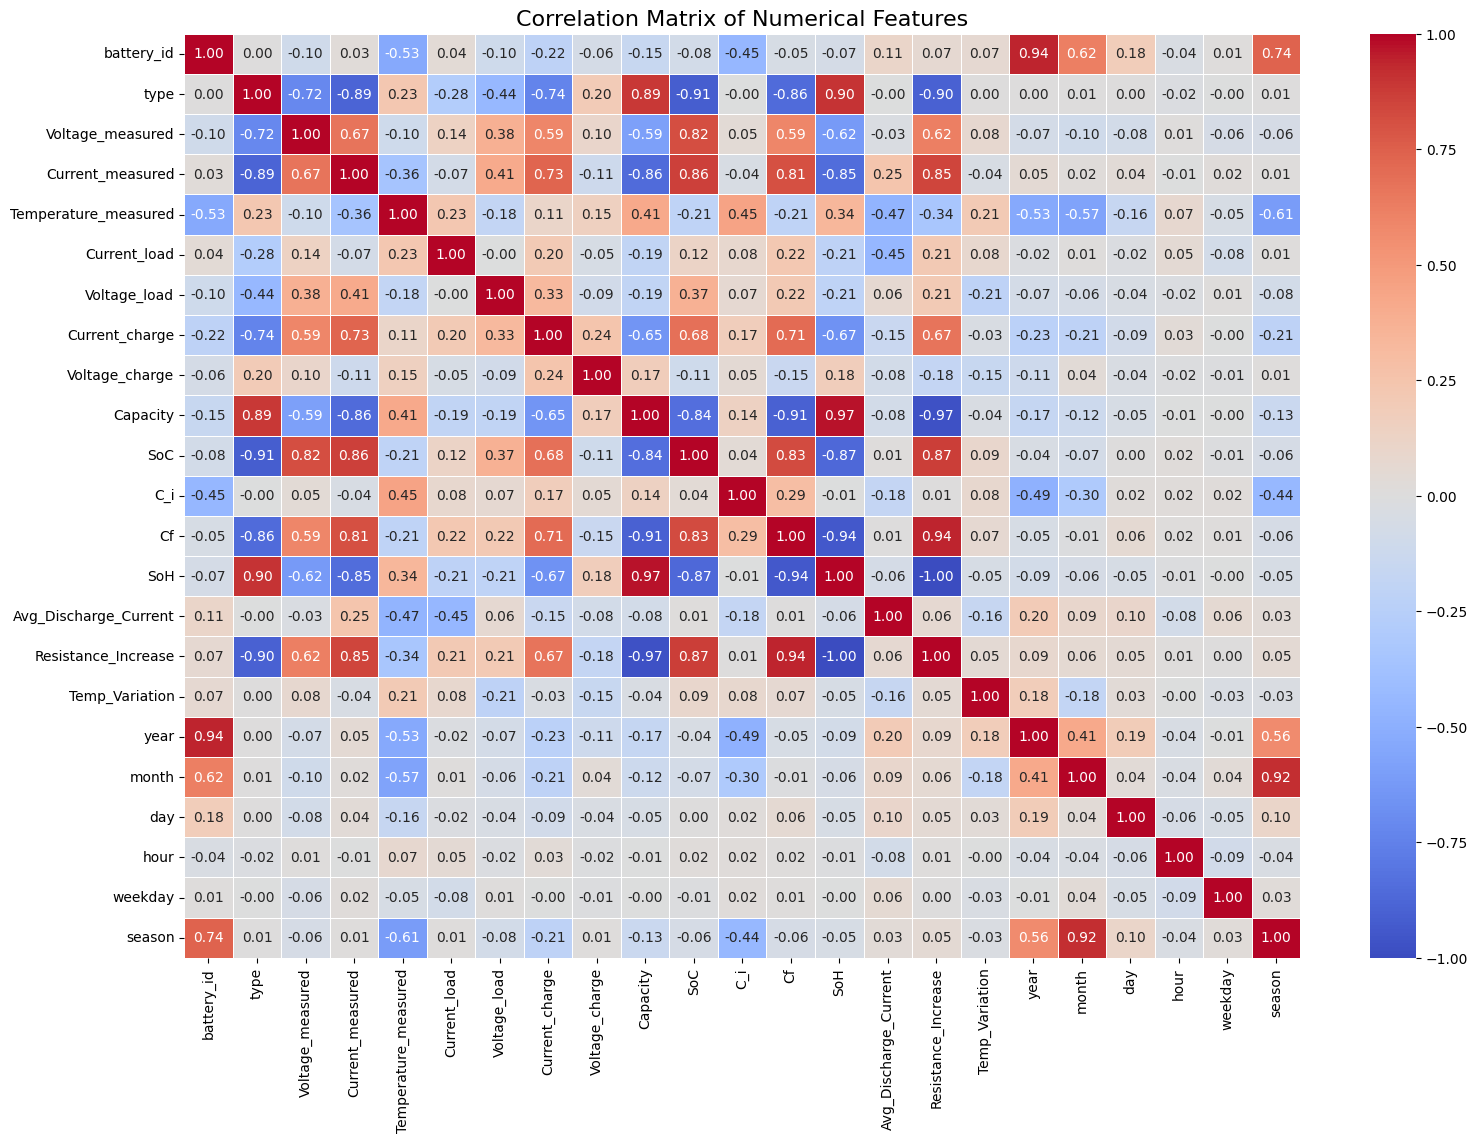

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

numerical_columns = combined_data.select_dtypes(include=['float64', 'int64', 'int32']).columns

correlation_matrix = combined_data[numerical_columns].corr()

plt.figure(figsize=(18, 12))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Matrix of Numerical Features", fontsize=16)
plt.show()

In [40]:

combined_data = combined_data.sort_values(by=['battery_id', 'start_time']).reset_index(drop=True)

In [41]:
combined_data[['SoC', 'SoH']].head()

,SoC,SoH
0,98.224573,0.000000
1,48.646130,100.000000
2,88.529420,0.000000
3,49.210941,99.452721
4,88.477578,0.000000


### LSTM

In [42]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

features = [
    'year', 'month', 'day', 'hour', 'weekday', 'season',
    'Voltage_measured', 'Current_measured', 'Temperature_measured', 
    'Current_load', 'Voltage_load', 'Avg_Discharge_Current', 'Resistance_Increase', 'Temp_Variation'
]

target_columns = ['SoC', 'SoH']

combined_data = combined_data.sort_values(by=['battery_id', 'start_time'])

scaler = MinMaxScaler()
combined_data[features] = scaler.fit_transform(combined_data[features])

X = combined_data[features].values
y = combined_data[target_columns].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# LSTM Model
model = Sequential([
    LSTM(50, activation='relu', return_sequences=True, input_shape=(1, X_train.shape[2])),
    LSTM(50, activation='relu'),
    Dense(25, activation='relu'),
    Dense(2)  # here the dense layer is uses as outputs for soh and soc
])

model.compile(optimizer='adam', loss='mse')

model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test), verbose=1)

y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"R² Score: {r2:.4f}")

c:\Users\dgoya\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 3219.2644 - val_loss: 1630.3208
Epoch 2/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 1024.6907 - val_loss: 191.3318
Epoch 3/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 118.3032 - val_loss: 170.5329
Epoch 4/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 95.8765 - val_loss: 161.1301
Epoch 5/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 87.8704 - val_loss: 144.3108
Epoch 6/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 73.1552 - val_loss: 125.0721
Epoch 7/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 69.2686 - val_loss: 107.0483
Epoch 8/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 57.2324 - val_loss: 102.9358
Epoch 9/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 52.0597 - val_loss: 120.6824
Epoch 10/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 43.6560 - val_loss: 115.7250
Epoch 11/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 44.4189 - val_loss: 155.1198
Epoch 12/50
2

### ML Algotithms

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


features = [
    'month', 'day', 'hour', 'weekday',
    'Voltage_measured', 'Current_measured', 'Temperature_measured', 
    'Current_load', 'Voltage_load', 'Avg_Discharge_Current', 'Resistance_Increase', 'Temp_Variation'
]
target_columns = ['SoC', 'SoH']


combined_data = combined_data.sort_values(by=['battery_id', 'start_time'])

scaler = MinMaxScaler()
combined_data[features] = scaler.fit_transform(combined_data[features])

X = combined_data[features].values
y = combined_data[target_columns].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

def evaluate_model(model, X_train, X_test, y_train, y_test, model_name, target_name):
    """
    Trains a given model and evaluates its performance for a single target variable.
    """
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"\n {model_name} Performance for {target_name}:")
    print(f"MAE: {mae:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"R² Score: {r2:.4f}")


y_train_soc, y_train_soh = y_train[:, 0], y_train[:, 1]
y_test_soc, y_test_soh = y_test[:, 0], y_test[:, 1]

gbr_model_soc = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
evaluate_model(gbr_model_soc, X_train, X_test, y_train_soc, y_test_soc, "Gradient Boosting Regressor", "SoC")

gbr_model_soh = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
evaluate_model(gbr_model_soh, X_train, X_test, y_train_soh, y_test_soh, "Gradient Boosting Regressor", "SoH")

xgb_model_soc = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
evaluate_model(xgb_model_soc, X_train, X_test, y_train_soc, y_test_soc, "XGBoost Regressor", "SoC")

xgb_model_soh = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
evaluate_model(xgb_model_soh, X_train, X_test, y_train_soh, y_test_soh, "XGBoost Regressor", "SoH")

rf_model_soc = RandomForestRegressor(n_estimators=100, random_state=42)
evaluate_model(rf_model_soc, X_train, X_test, y_train_soc, y_test_soc, "Random Forest Regressor", "SoC")

rf_model_soh = RandomForestRegressor(n_estimators=100, random_state=42)
evaluate_model(rf_model_soh, X_train, X_test, y_train_soh, y_test_soh, "Random Forest Regressor", "SoH")



 Gradient Boosting Regressor Performance for SoC:
MAE: 5.1321
MSE: 169.4046
R² Score: 0.8706

 Gradient Boosting Regressor Performance for SoH:
MAE: 0.1559
MSE: 0.1554
R² Score: 0.9399

 XGBoost Regressor Performance for SoC:
MAE: 4.3448
MSE: 110.0134
R² Score: 0.8949

 XGBoost Regressor Performance for SoH:
MAE: 0.6094
MSE: 5.0989
R² Score: 0.9374

 Random Forest Regressor Performance for SoC:
MAE: 4.7231
MSE: 141.3791
R² Score: 0.8821000000000001

 Random Forest Regressor Performance for SoH:
MAE: 0.2168
MSE: 0.7844
R² Score: 0.9396


In [44]:
import numpy as np
import matplotlib.pyplot as plt


y_pred_soc_xgb = xgb_model_soc.predict(X_test)
y_pred_soh_xgb = xgb_model_soh.predict(X_test)


test_indices = combined_data.index[-len(y_test) :]
forecasted_times = combined_data.loc[test_indices, 'start_time'].values

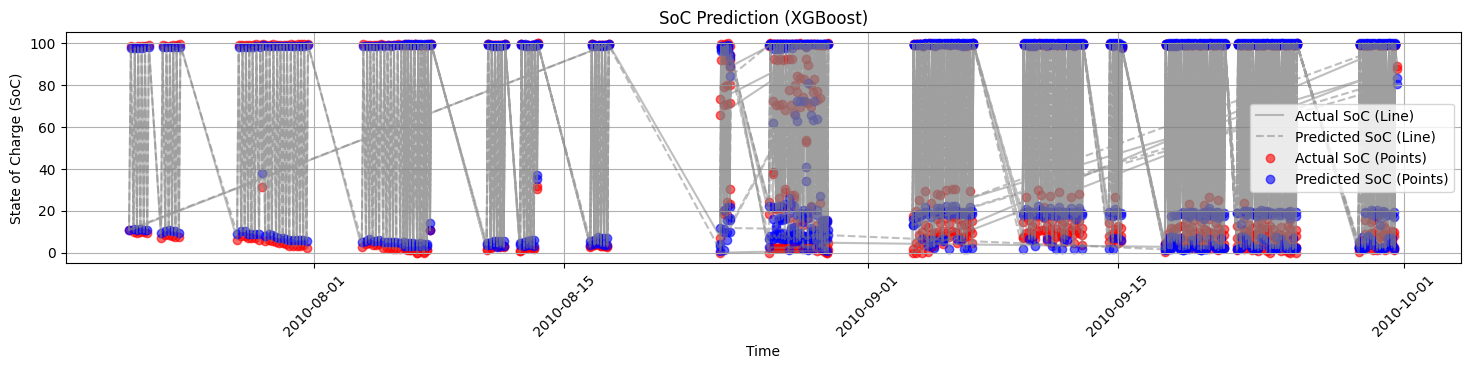

In [45]:
# 🔹 Plot for SoC (State of Charge)
plt.figure(figsize=(18, 3))
plt.plot(forecasted_times, y_test_soc, linestyle='-', color='gray', alpha=0.5, label="Actual SoC (Line)")  
plt.plot(forecasted_times, y_pred_soc_xgb, linestyle='--', color='gray', alpha=0.5, label="Predicted SoC (Line)")  
plt.scatter(forecasted_times, y_test_soc, color='red', label="Actual SoC (Points)", alpha=0.6)
plt.scatter(forecasted_times, y_pred_soc_xgb, color='blue', label="Predicted SoC (Points)", alpha=0.6)

plt.xlabel("Time")
plt.ylabel("State of Charge (SoC)")
plt.title("SoC Prediction (XGBoost)")
plt.legend()
plt.xticks(rotation=45)
plt.grid()
plt.show()


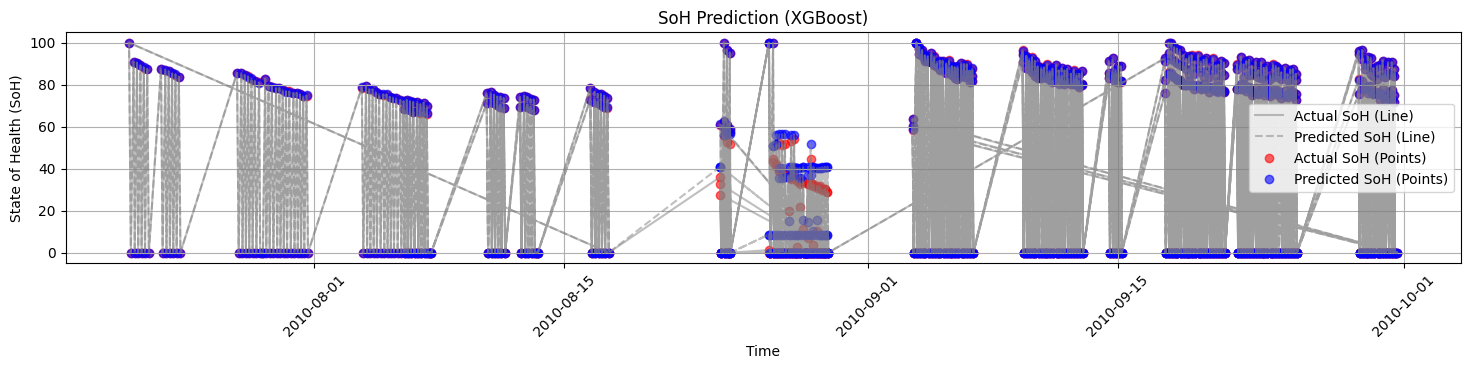

In [46]:
# 🔹 Plot for SoH (State of Health)
plt.figure(figsize=(18, 3))
plt.plot(forecasted_times, y_test_soh, linestyle='-', color='gray', alpha=0.5, label="Actual SoH (Line)")
plt.plot(forecasted_times, y_pred_soh_xgb, linestyle='--', color='gray', alpha=0.5, label="Predicted SoH (Line)")
plt.scatter(forecasted_times, y_test_soh, color='red', label="Actual SoH (Points)", alpha=0.6)
plt.scatter(forecasted_times, y_pred_soh_xgb, color='blue', label="Predicted SoH (Points)", alpha=0.6)

plt.xlabel("Time")
plt.ylabel("State of Health (SoH)")
plt.title("SoH Prediction (XGBoost)")
plt.legend()
plt.xticks(rotation=45)
plt.grid()
plt.show()

### Single Prediction

In [ ]:
import numpy as np

month = 2                    # February
day = 19                     # 19th day
hour = 15                    # 3 PM
weekday = 1                  # Monday
voltage_measured = 3.7       # Measured voltage (V)
current_measured = 1.5       # Measured current (A)
temperature_measured = 25.0  # Measured temperature (°C)
current_load = 0.8           # Load current (A)
voltage_load = 3.6           # Load voltage (V)
avg_discharge_current = 0.9  # Average discharge current (A)
resistance_increase = 0.05   # Internal resistance increase (Ω)
temp_variation = 1.2         # Temperature variation (°C)

single_input = np.array([[month, day, hour, weekday, 
                          voltage_measured, current_measured, temperature_measured, 
                          current_load, voltage_load, avg_discharge_current, 
                          resistance_increase, temp_variation]])

single_input_scaled = scaler.transform(single_input)

predicted_soc = xgb_model_soc.predict(single_input_scaled)[0]
predicted_soh = xgb_model_soh.predict(single_input_scaled)[0]

print(f"Predicted SoC: {predicted_soc:.4f}")
print(f"Predicted SoH: {predicted_soh:.4f}")

Predicted SoC: 91.8698
Predicted SoH: 94.9599


c:\Users\dgoya\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


### Forecasting

## LSTM Model

In [49]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

features = [
    'battery_id', 'month', 'day', 'hour', 'weekday',
    'Voltage_measured', 'Current_measured', 'Temperature_measured', 
    'Current_load', 'Voltage_load', 'Avg_Discharge_Current', 'Resistance_Increase', 'Temp_Variation'
]

target_columns = ['SoC', 'SoH']

combined_data = combined_data.sort_values(by=['battery_id', 'start_time'])

scaler = MinMaxScaler()
combined_data[features] = scaler.fit_transform(combined_data[features])

def create_dataset(data, target_col, window_size=30, forecast_horizon=1):
    X, y = [], []
    features = [
    'battery_id', 'month', 'day', 'hour', 'weekday',
    'Voltage_measured', 'Current_measured', 'Temperature_measured', 
    'Current_load', 'Voltage_load', 'Avg_Discharge_Current', 'Resistance_Increase', 'Temp_Variation']

    for i in range(window_size, len(data) - forecast_horizon + 1):
        X.append(data.iloc[i - window_size:i][features].values)  
        y.append(data.iloc[i + forecast_horizon - 1][target_col])  

    return np.array(X), np.array(y)


X, y_SoC = create_dataset(combined_data, 'SoC')
X, y_SoH = create_dataset(combined_data, 'SoH')

X_train, X_test, y_train_SoC, y_test_SoC = train_test_split(X, y_SoC, test_size=0.2, random_state=42)
X_train, X_test, y_train_SoH, y_test_SoH = train_test_split(X, y_SoH, test_size=0.2, random_state=42)

def build_lstm_model(input_shape):
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=input_shape),
        LSTM(64, return_sequences=False),
        Dense(64, activation='relu'),
        Dense(1) 
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=1e-6)

In [50]:

model_SoC = build_lstm_model((X_train.shape[1], X_train.shape[2]))
history_SoC = model_SoC.fit(
    X_train, y_train_SoC, epochs=100, batch_size=32,
    validation_data=(X_test, y_test_SoC), verbose=1, callbacks=[reduce_lr]
)

y_pred_SoC_LSTM = model_SoC.predict(X_test)


mae_SoC = mean_absolute_error(y_test_SoC, y_pred_SoC_LSTM)
mse_SoC = mean_squared_error(y_test_SoC, y_pred_SoC_LSTM)
rmse_SoC = np.sqrt(mse_SoC)
r2_SoC = r2_score(y_test_SoC, y_pred_SoC_LSTM)

print("SoC Prediction Evaluation Metrics:")
print("R² Score:", r2_SoC)
print("Mean Absolute Error (MAE):", mae_SoC)
print("Mean Squared Error (MSE):", mse_SoC)
print("Root Mean Squared Error (RMSE):", rmse_SoC)

Epoch 1/100


c:\Users\dgoya\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - loss: 3605.5444 - val_loss: 1597.6820 - learning_rate: 0.0010
Epoch 2/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 1583.1616 - val_loss: 1607.7225 - learning_rate: 0.0010
Epoch 3/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - loss: 1606.4552 - val_loss: 1597.6465 - learning_rate: 0.0010
Epoch 4/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 1604.3618 - val_loss: 1599.5570 - learning_rate: 0.0010
Epoch 5/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 1599.0259 - val_loss: 1597.9149 - learning_rate: 0.0010
Epoch 6/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 1607.3729 - val_loss: 1597.2792 - learning_rate: 0.0010
Epoch 7/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 1617.3870 - val_loss: 1566.7257 - learning_rate: 0.0010
Epoch 8/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 1103.5596 - val_loss: 243.2258 - learning_rate: 0.0010
Epoch 9/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 247.821

In [51]:

model_SoH = build_lstm_model((X_train.shape[1], X_train.shape[2]))
history_SoH = model_SoH.fit(
    X_train, y_train_SoH, epochs=100, batch_size=32,
    validation_data=(X_test, y_test_SoH), verbose=1, callbacks=[reduce_lr]
)


y_pred_SoH_LSTM = model_SoH.predict(X_test)


mae_SoH = mean_absolute_error(y_test_SoH, y_pred_SoH_LSTM)
mse_SoH = mean_squared_error(y_test_SoH, y_pred_SoH_LSTM)
rmse_SoH = np.sqrt(mse_SoH)
r2_SoH = r2_score(y_test_SoH, y_pred_SoH_LSTM)


print("SoH Prediction Evaluation Metrics:")
print("R² Score:", r2_SoH)
print("Mean Absolute Error (MAE):", mae_SoH)
print("Mean Squared Error (MSE):", mse_SoH)
print("Root Mean Squared Error (RMSE):", rmse_SoH)

Epoch 1/100


c:\Users\dgoya\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - loss: 2302.6726 - val_loss: 1714.8091 - learning_rate: 0.0010
Epoch 2/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 1693.0520 - val_loss: 1715.3716 - learning_rate: 0.0010
Epoch 3/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 1668.1525 - val_loss: 1715.3218 - learning_rate: 0.0010
Epoch 4/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 1698.6738 - val_loss: 1714.4580 - learning_rate: 0.0010
Epoch 5/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 1678.7561 - val_loss: 899.8911 - learning_rate: 0.0010
Epoch 6/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 472.8958 - val_loss: 241.5298 - learning_rate: 0.0010
Epoch 7/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 188.3328 - val_loss: 166.9295 - learning_rate: 0.0010
Epoch 8/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 149.7839 - val_loss: 151.1038 - learning_rate: 0.0010
Epoch 9/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 139.9899 - va

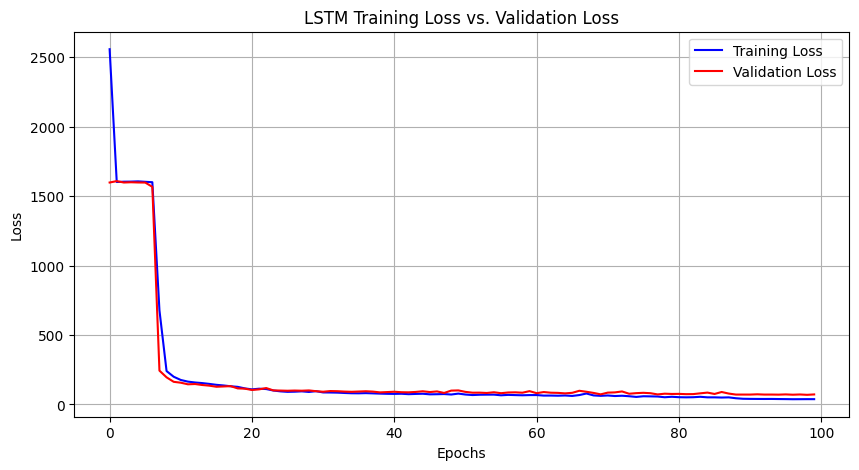

In [52]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(history_SoC.history['loss'], label='Training Loss', color='blue')
plt.plot(history_SoC.history['val_loss'], label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('LSTM Training Loss vs. Validation Loss')
plt.legend()
plt.grid()
plt.show()

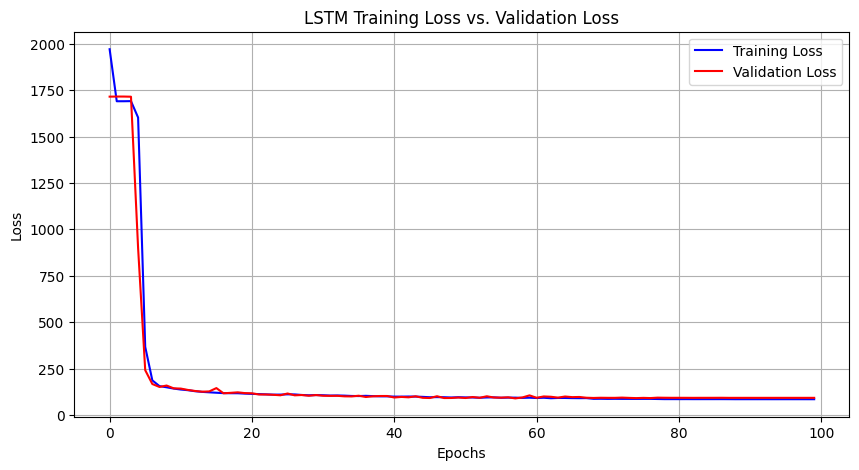

In [53]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 5))
plt.plot(history_SoH.history['loss'], label='Training Loss', color='blue')
plt.plot(history_SoH.history['val_loss'], label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('LSTM Training Loss vs. Validation Loss')
plt.legend()
plt.grid()
plt.show()

### Hybrid LSTM + XGBoost

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

features = [
    'month', 'day', 'hour', 'weekday',
    'Voltage_measured', 'Current_measured', 'Temperature_measured', 
    'Current_load', 'Voltage_load', 'Avg_Discharge_Current', 'Resistance_Increase', 'Temp_Variation'
]
target_columns = ['SoC', 'SoH']


combined_data = combined_data.sort_values(by=['battery_id', 'start_time'])
scaler = MinMaxScaler()
combined_data[features] = scaler.fit_transform(combined_data[features])


X = combined_data[features].values
y = combined_data[target_columns].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=False
)

X_train_lstm = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_lstm = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(64, activation='relu', return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))

    model.add(LSTM(32, activation='relu', return_sequences=False))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(16, activation='relu', name='feature_layer'))
    model.add(Dense(2, activation='linear'))  
    return model

lstm_model = build_lstm_model((X_train_lstm.shape[1], X_train_lstm.shape[2]))
lstm_model.compile(optimizer='adam', loss='mse')

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-6)
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
model_checkpoint = ModelCheckpoint('best_lstm_model.keras', monitor='val_loss', save_best_only=True, verbose=1)
callbacks_list = [reduce_lr, early_stop, model_checkpoint]

history = lstm_model.fit(
    X_train_lstm, y_train,
    epochs=200,
    batch_size=32,
    validation_data=(X_test_lstm, y_test),
    callbacks=callbacks_list,
    verbose=1
)

_ = lstm_model.predict(X_train_lstm[:1])

feature_extractor = tf.keras.Model(
    inputs=lstm_model.layers[0].input,
    outputs=lstm_model.get_layer('feature_layer').output
)

train_features = feature_extractor.predict(X_train_lstm)
test_features = feature_extractor.predict(X_test_lstm)

param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'learning_rate': [0.1, 0.05, 0.01],
    'max_depth': [3, 4, 5, 6],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

xgb_soc = XGBRegressor(random_state=42)
random_search_soc = RandomizedSearchCV(
    estimator=xgb_soc,
    param_distributions=param_grid,
    n_iter=100,  
    cv=3,
    scoring='neg_mean_squared_error',
    verbose=1,
    random_state=42,
    n_jobs=-1
)
random_search_soc.fit(train_features, y_train[:, 0])
best_xgb_soc = random_search_soc.best_estimator_
print("Best parameters for SoC:", random_search_soc.best_params_)

xgb_soh = XGBRegressor(random_state=42)
random_search_soh = RandomizedSearchCV(
    estimator=xgb_soh,
    param_distributions=param_grid,
    n_iter=100, 
    cv=3,
    scoring='neg_mean_squared_error',
    verbose=1,
    random_state=42,
    n_jobs=-1
)
random_search_soh.fit(train_features, y_train[:, 1])
best_xgb_soh = random_search_soh.best_estimator_
print("Best parameters for SoH:", random_search_soh.best_params_)

y_pred_soc = best_xgb_soc.predict(test_features)
y_pred_soh = best_xgb_soh.predict(test_features)

def evaluate_model(y_true, y_pred, target_name):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"\n{target_name} Prediction:")
    print(f"MAE: {mae:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"R² Score: {r2:.4f}")

evaluate_model(y_test[:, 0], y_pred_soc, "SoC")
evaluate_model(y_test[:, 1], y_pred_soh, "SoH")


c:\Users\dgoya\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
138/141 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3803.3208
Epoch 1: val_loss improved from inf to 1717.41980, saving model to best_lstm_model.keras
141/141 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 3778.5413 - val_loss: 1717.4198 - learning_rate: 0.0010
Epoch 2/200
137/141 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1558.9248
Epoch 2: val_loss improved from 1717.41980 to 1611.90698, saving model to best_lstm_model.keras
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1558.1636 - val_loss: 1611.9070 - learning_rate: 0.0010
Epoch 3/200
123/141 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1285.6575
Epoch 3: val_loss improved from 1611.90698 to 237.13789, saving model to best_lstm_model.keras
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1237.7358 - val_loss: 237.1379 - learning_rate: 0.0010
Epoch 4/200
132/141 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 269.7943
Epoch 4: val_loss improved from 237.13789 to 205.98451, saving model to best_lstm_model.keras
141/141 ━━━━━━━━━━━━━━━━━━━━ 

## Hybrid LSTM + Randomforest

In [67]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


features = [
    'month', 'day', 'hour', 'weekday',
    'Voltage_measured', 'Current_measured', 'Temperature_measured', 
    'Current_load', 'Voltage_load', 'Avg_Discharge_Current', 'Resistance_Increase', 'Temp_Variation'
]
target_columns = ['SoC', 'SoH']

combined_data = combined_data.sort_values(by=['battery_id', 'start_time'])
scaler = MinMaxScaler()
combined_data[features] = scaler.fit_transform(combined_data[features])

X = combined_data[features].values
y = combined_data[target_columns].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=False
)

X_train_lstm = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_lstm = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(64, activation='relu', return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(LSTM(32, activation='relu', return_sequences=False))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(16, activation='relu', name='feature_layer'))  
    model.add(Dense(2, activation='linear')) 
    return model

lstm_model = build_lstm_model((X_train_lstm.shape[1], X_train_lstm.shape[2]))
lstm_model.compile(optimizer='adam', loss='mse')


reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-6)
model_checkpoint = ModelCheckpoint('best_lstm_model.keras', monitor='val_loss', save_best_only=True, verbose=1)
callbacks_list = [reduce_lr, model_checkpoint]


history = lstm_model.fit(
    X_train_lstm, y_train,
    epochs=200,
    batch_size=32,
    validation_data=(X_test_lstm, y_test),
    callbacks=callbacks_list,
    verbose=1
)


_ = lstm_model.predict(X_train_lstm[:1])


feature_extractor = tf.keras.Model(
    inputs=lstm_model.layers[0].input,
    outputs=lstm_model.get_layer('feature_layer').output
)


train_features = feature_extractor.predict(X_train_lstm)
test_features = feature_extractor.predict(X_test_lstm)


rf_param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

rf_soc = RandomForestRegressor(random_state=42)
random_search_soc = RandomizedSearchCV(
    estimator=rf_soc,
    param_distributions=rf_param_grid,
    n_iter=100, 
    cv=3,
    scoring='neg_mean_squared_error',
    verbose=1,
    random_state=42,
    n_jobs=-1
)
random_search_soc.fit(train_features, y_train[:, 0])
best_rf_soc = random_search_soc.best_estimator_
print("Best parameters for SoC:", random_search_soc.best_params_)


rf_soh = RandomForestRegressor(random_state=42)
random_search_soh = RandomizedSearchCV(
    estimator=rf_soh,
    param_distributions=rf_param_grid,
    n_iter=100, 
    cv=3,
    scoring='neg_mean_squared_error',
    verbose=1,
    random_state=42,
    n_jobs=-1
)
random_search_soh.fit(train_features, y_train[:, 1])
best_rf_soh = random_search_soh.best_estimator_
print("Best parameters for SoH:", random_search_soh.best_params_)

y_pred_soc = best_rf_soc.predict(test_features)
y_pred_soh = best_rf_soh.predict(test_features)

def evaluate_model(y_true, y_pred, target_name):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"\n{target_name} Prediction:")
    print(f"MAE: {mae:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"R² Score: {r2:.4f}")

evaluate_model(y_test[:, 0], y_pred_soc, "SoC")
evaluate_model(y_test[:, 1], y_pred_soh, "SoH")


c:\Users\dgoya\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
127/141 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3976.8457
Epoch 1: val_loss improved from inf to 1735.68848, saving model to best_lstm_model.keras
141/141 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - loss: 3890.8977 - val_loss: 1735.6885 - learning_rate: 0.0010
Epoch 2/200
133/141 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1585.4434
Epoch 2: val_loss improved from 1735.68848 to 1624.95496, saving model to best_lstm_model.keras
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1582.3678 - val_loss: 1624.9550 - learning_rate: 0.0010
Epoch 3/200
136/141 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1301.2113
Epoch 3: val_loss improved from 1624.95496 to 248.81219, saving model to best_lstm_model.keras
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1284.4368 - val_loss: 248.8122 - learning_rate: 0.0010
Epoch 4/200
133/141 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 236.1798
Epoch 4: val_loss improved from 248.81219 to 209.92477, saving model to best_lstm_model.keras
141/141 ━━━━━━━━━━━━━━━━━━━━